In [2]:
%matplotlib inline
import numpy as np
import random
from __future__ import division
import wave, struct, numpy as np, matplotlib.mlab as mlab, pylab as pl
import matplotlib.pyplot as plt
import math

1e-06
(11263, 129)


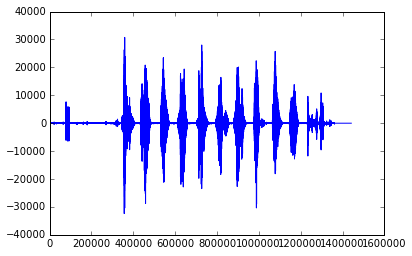

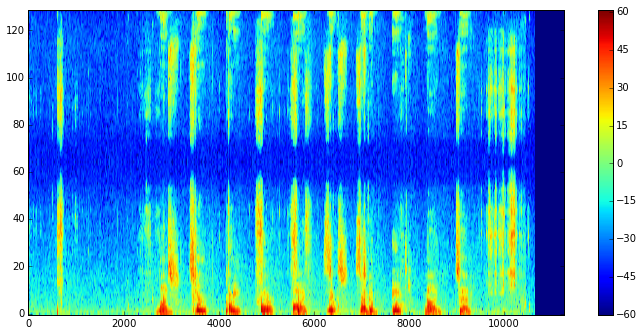

In [3]:
filename = "CG.wav"
filename = 'CML_Recording_Both.wav'

w = wave.open(filename,"rb")

#returns a named tuple (nchannels, sampwidth, framerate, 
# nframes, comptype, compname)
waveParams = w.getparams()

s = w.readframes(waveParams[3])
w.close()
waveArray = np.fromstring(s, np.int16)

pl.figure()
pl.plot(waveArray)

spectrum, freq, bins = mlab.specgram(waveArray, NFFT=256,Fs=waveParams[2],sides='onesided')
spectrum += 1e-6

print(np.min(np.min(spectrum, axis=1), axis=0))
print(spectrum.T.shape)
fig=pl.figure(figsize=(12,12))
ax = fig.add_subplot(2,1,1)
#generate a log frequency spectrogram

imgplot = ax.imshow(10*np.log10(spectrum), origin='lower', aspect = 'auto')
fig.colorbar(imgplot)



In [47]:
from scipy.io import wavfile

# returns wave array of one track of stereo .wav file
def get_wave_stereo(filename):
    rate, data = wavfile.read(filename)
    data = data[:,0]
    return data, rate
    
# returns wave array of filename (.wav file)
def get_wave(filename):
    w = wave.open(filename,"rb")
    waveParams = w.getparams()
    s = w.readframes(waveParams[3])
    w.close()
    waveArray = np.fromstring(s, np.int16)
    return waveArray

# power spectrogram is the absolute value SQUARED of the stft
def get_spectrogram(stft):
    return np.square(np.absolute(stft))

# takes in wave file as input
# win_size is the length of the window in samples
# overlap is the amount of overlap between windows in samples
def my_stft(wave, win_size, overlap):
    # power sinbell analysis window
    win = sinebell(win_size, overlap)
    # make the frames
    frames, wave_pad = make_frames(wave, win, overlap)
    # fft, for each column
    stft = np.fft.fft(frames, axis = 0)
    # keep the spectrum associated with the positive frequencies (potentially times to the upper frequencies)
    if len(win)%2 == 0:
        stft = stft[:int(len(win)/2)+1]
    else:
        stft = stft[:int((len(win)+1)/2)]
    return stft, wave_pad
    
# create sinebell window of length win_size, with overlap, DONE
def sinebell(win_size, overlap):
    win = np.zeros(win_size)
    win[0:overlap] = np.sin( math.pi * (np.array([i for i in range(overlap)])) / (2*(overlap-1)) )
    win[overlap : win_size - overlap] = 1
    win[win_size - overlap:] = np.sin( math.pi * (win_size - np.array([i for i in range(win_size-overlap, win_size)]) - 1 ) / (2*(overlap - 1)) )
    return win

# computes sinebell window with smooth edges, this should be an improvement
def power_sinebell(win_size, overlap):
    win = np.zeros(win_size)
    win[0:overlap] = np.sin( math.pi * (np.array([i for i in range(overlap)])) / (2*(overlap-1)) )**2
    win[overlap : win_size - overlap] = 1
    win[win_size - overlap:] = np.sin( math.pi * (win_size - np.array([i for i in range(win_size-overlap, win_size)]) - 1 ) / (2*(overlap - 1)) )**2
    return win

# x is the input signal, win is the analysis window, overlap
# returns frame matrix and padded input signal x_pad
def make_frames(x, win, overlap):
    win_len = win.shape[0]
    x_len = len(x)
    
    # number of frames
    num_frames = int(np.ceil((x_len + overlap)/(win_len - overlap)))
    
    # initializing zero padded signal
    pad_len = int(overlap + num_frames * (win_len - overlap))
    x_pad = np.zeros(pad_len)
    x_pad[overlap: overlap + x_len] = x
    
    # index of beginning of each frame in x_pad
    frame_ind = np.array([i for i in range(num_frames)]) * (win_len - overlap)
    
    # initialize frames matrix
    frames = np.zeros((win_size, num_frames))
    for i in range(num_frames):
        frames[:,i] = (x_pad[frame_ind[i] : frame_ind[i] + win_size] * win)
    
    return frames, x_pad
    
def my_istft(stft, win_size, overlap):
    # power sinbell analysis window
    win = sinebell(win_size, overlap)
    (num_coeff, num_frames) = stft.shape
    
    # recover full stft by conjugate symmetry of the fourier expansion of real signals
    stft_full = np.zeros((win_size, num_frames), dtype = np.complex128)
    stft_full[:num_coeff,:] = stft
    
    # reasoning: stft[ num_coeff - 1] is the both the negative and positive Nyquist frequency if win_size is even
    # thus, we take the conjugate only of stft[ num_coeff - 2:0:-1 ]
    if win_size%2 == 0:
        stft_full[num_coeff:, :] = np.conj(stft[num_coeff-2:0:-1, :])
    else:
        stft_full[num_coeff:,:] = np.conj(stft[num_coeff-1:0:-1, :])
        
    # take inverse fft of recovered stft
    istft = np.fft.ifft(stft_full, axis = 0)
    # reconstruct padded signal by taking overlap into account
    x_pad = overlap_add(istft, win_size, overlap)
    return x_pad

def overlap_add(signal, win_size, overlap):
    
    win = sinebell(win_size, overlap)
    (temp, num_frames) = signal.shape

    if temp != win_size:
        print("Dimensions of ISTFT are wrong!")
    
    pad_len = overlap + num_frames * (win_size - overlap)
    x_pad = np.zeros(pad_len, dtype = np.complex128)
    
     # index of beginning of each frame in x_pad
    frame_ind = np.array([i for i in range(num_frames)]) * (win_size - overlap)
    
    # do we really need the window again here?
    x_pad[frame_ind[0]:frame_ind[0] + win_size] = signal[:,0] * win
    for i in range(1,num_frames):
        x_pad[frame_ind[i]:frame_ind[i] + win_size] = x_pad[frame_ind[i]:frame_ind[i] + win_size] + signal[:,i] * win
    return x_pad

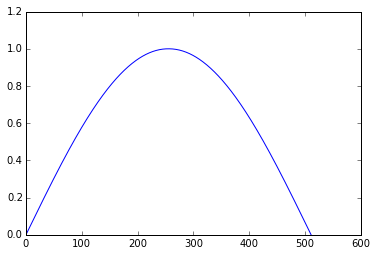

In [48]:
# pretty sinebell window, gotte make this plot better, i.e. increase range of y axis
win_size = 512
overlap = 256
win = sinebell(win_size, overlap)
pwin = power_sinebell(win_size, overlap)
plt.ylim((0,1.2))
plt.plot([i for i in range(win_size)], win)

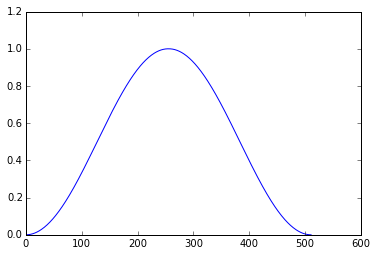

In [49]:
plt.ylim((0,1.2))
plt.plot([i for i in range(win_size)], pwin)

In [35]:
# filenames = "CML_Recording_Both.wav", "CG.wav"
wave_arr = get_wave("CML_Recording_Both.wav")
wave_arr.shape

(1441792,)

In [82]:
wave_arr, framerate = get_wave_stereo("CML_Recording_Both.wav")
wave_arr = wave_arr.astype(np.float64)

In [81]:
print(np.linalg.norm(wave_arr))
print(wave_arr.dtype)
wave_arr = wave_arr/32768
print(np.linalg.norm(wave_arr))
print(wave_arr.dtype)
print(max(abs(wave_arr)))

nan
int16
61.8056561558
float64
0.988525390625


/Users/sebastianament/anaconda/lib/python3.4/site-packages/numpy/linalg/linalg.py:2061: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(sqnorm)


In [65]:
frames, x_pad = make_frames(wave_arr, win, overlap)

In [66]:
print(wave_arr.shape)
print(frames.shape)
print(x_pad.shape)

(720896,)
(512, 2817)
(721408,)


In [67]:
stft, wave_pad = my_stft(wave_arr, win_size, overlap)

In [75]:
spectrum = get_spectrogram(stft)

1e-08
(2817, 257)


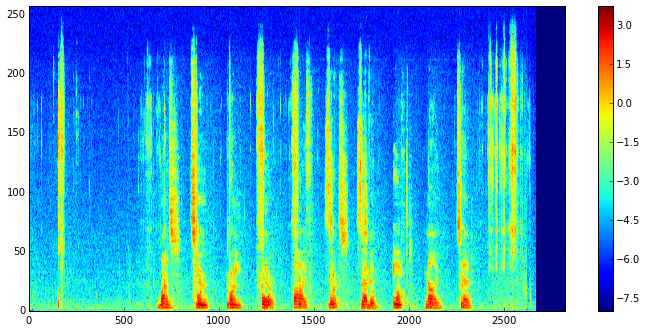

In [76]:
# test the spectrogram:!
spectrum += 1e-8 # to prevent divide by zero in log10 errors

print(np.min(np.min(spectrum, axis=1), axis=0))
print(spectrum.T.shape)
fig=pl.figure(figsize=(12,12))
ax = fig.add_subplot(2,1,1)
#generate a log frequency spectrogram
imgplot = ax.imshow(np.log10(spectrum), origin='lower', aspect = 'auto')
fig.colorbar(imgplot)

In [83]:
x_pad = my_istft(stft, win_size, overlap)

In [84]:
np.linalg.norm(x_pad - wave_pad)

2.2965417529216045e-14